## Sparse LD Matrix Calculation on GPU

This notebook demonstrates the use of LD matrix functions with support for complex sparsity patterns.  This is useful for computing LD for variants based on fixed windows or genomic distance.

In [ ]:
import dask
import numpy as np
from lib import api
from lib.stats.ld_matrix.dask_backend import ld_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
%run nb/paths.py
%run nb/plotting.py

In [2]:
from dask.distributed import Client
client = Client(processes=False)

In [3]:
path = PLINK_HAPMAP_PATH_01
path

PosixPath('/lab/data/gwas/tutorial/1_QC_GWAS/HapMap_3_r3_1')

In [4]:
%%time
ds = api.read_plink(path, chunks='auto', fam_sep=' ', bim_sep='\t')
ds

CPU times: user 7.12 s, sys: 1.12 s, total: 8.24 s
Wall time: 7.99 s


<xarray.Dataset>
Dimensions:     (sample: 165, variant: 1457897)
Coordinates:
  * variant     (variant) int64 0 1 2 3 4 ... 1457893 1457894 1457895 1457896
  * sample      (sample) int64 0 1 2 3 4 5 6 7 ... 158 159 160 161 162 163 164
Data variables:
    data        (variant, sample) int8 dask.array<chunksize=(813440, 165), meta=np.ndarray>
    is_masked   (variant, sample) bool dask.array<chunksize=(813440, 165), meta=np.ndarray>
    sample_id   (sample) int64 dask.array<chunksize=(165,), meta=np.ndarray>
    fam_id      (sample) object dask.array<chunksize=(165,), meta=np.ndarray>
    pat_id      (sample) object dask.array<chunksize=(165,), meta=np.ndarray>
    mat_id      (sample) object dask.array<chunksize=(165,), meta=np.ndarray>
    is_female   (sample) int64 dask.array<chunksize=(165,), meta=np.ndarray>
    phenotype   (sample) int64 dask.array<chunksize=(165,), meta=np.ndarray>
    contig      (variant) int64 dask.array<chunksize=(1457897,), meta=np.ndarray>
    variant_id  (variant) object dask.array<chunksize=(1457897,), meta=np.ndarray>
    cm_pos      (variant) int64 dask.array<chunksize=(1457897,), meta=np.ndarray>
    pos         (variant) int64 dask.array<chunksize=(1457897,), meta=np.ndarray>
    a1          (variant) object dask.array<chunksize=(1457897,), meta=np.ndarray>
    a2          (variant) object dask.array<chunksize=(1457897,), meta=np.ndarray>
Attributes:
    type:     GenotypeCountDataset

Check standard deviation across rows to see how often variants have no variance:

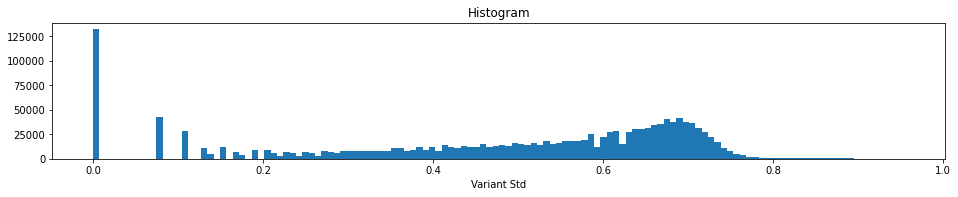

In [6]:
ds.data.std(dim='sample').rename('Variant Std').plot.hist(bins=128)
plt.gcf().set_size_inches(16, 2.5)

Define an LD matrix based on a moving base pair window:

In [5]:
%%time
# Use 100kbp windows for LD comparisons
intervals = api.axis_intervals(ds, window=100_000, unit='physical', target_chunk_size=None, backend='numba')
# Use no lower R2 threshold (it's a small dataset so we can pull everything)
ldm = api.ld_matrix(ds, intervals=intervals, threshold=None, backend='dask/numba')

CPU times: user 3.52 s, sys: 232 ms, total: 3.75 s
Wall time: 3.62 s


In [6]:
ldm

,i,j,value
npartitions=24,,,
,int32,int32,float32
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


The above matrix was defined by interval calculations that are also useful for analyzing variant density:

In [7]:
ais, cis = intervals
ais.to_dataset('var').to_dataframe().sample(10, random_state=1)

,group,index,start,stop,count
axis,,,,,
688454,8,688454,688454,688517,63
514952,5,514952,514952,515019,67
492494,5,492494,492494,492531,37
15237,1,15237,15237,15325,88
674281,7,674281,674281,674326,45
153046,2,153046,153046,153085,39
393782,4,393782,393782,393818,36
1380377,20,1380377,1380377,1380468,91
987729,12,987729,987729,987784,55


Check the distribution of variants within each moving base pair window:

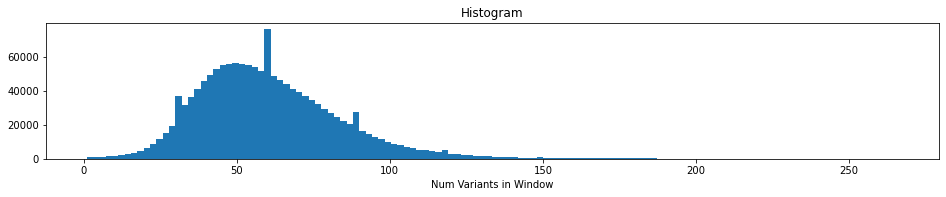

In [8]:
ais.to_dataset('var')['count'].rename('Num Variants in Window').plot.hist(bins=128)
plt.gcf().set_size_inches(16, 2.5)

Run the actual calculations:

In [9]:
%%time
# Force to single thread with only one GPU installed
df = ldm.compute(scheduler='single-threaded')
df.head()

CPU times: user 4.93 s, sys: 1.15 s, total: 6.08 s
Wall time: 5.8 s


,i,j,value
pair,,,
0,0,0,1.0
1,0,1,NaN
2,1,1,1.0
3,2,2,1.0
4,2,3,NaN


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88568878 entries, 0 to 9401
Data columns (total 3 columns):
i        int32
j        int32
value    float32
dtypes: float32(1), int32(2)
memory usage: 1.6 GB


R2 distribution across all variants compared:

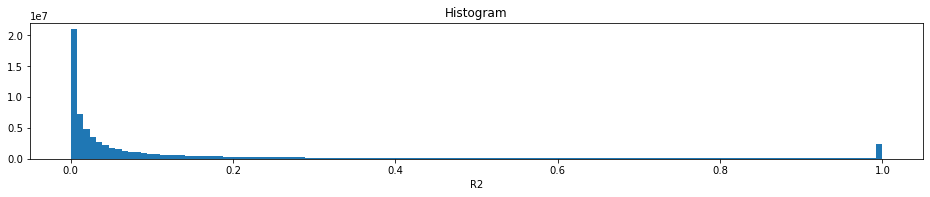

In [11]:
df.value.to_xarray().rename('R2').plot.hist(bins=128)
plt.gcf().set_size_inches(16, 2.5)

Visualize LD for the variant comparisons made noting that gaps indicate variants with zero variance:

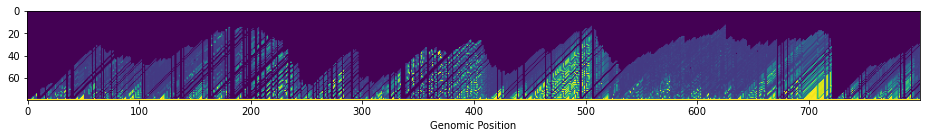

In [13]:
n, m = 800, 80
plot(image(df, n, m, .1))

Do the same thing as above but use fixed variant window/step sizes instead (rather than rolling base pair ranges):

CPU times: user 5.44 s, sys: 911 ms, total: 6.35 s
Wall time: 6.05 s


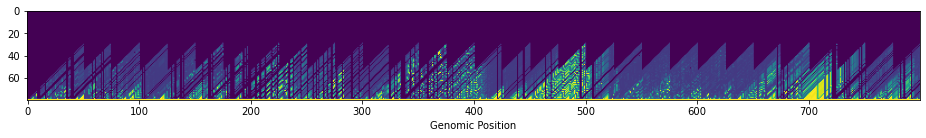

In [15]:
%%time
intervals = api.axis_intervals(ds, window=50, step=25, unit='index', target_chunk_size=None, backend='numba')
df = api.ld_matrix(ds, intervals=intervals, threshold=None).compute(scheduler='single-threaded')
plot(image(df, n, m, .1))